In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from Cyclist_env_RDA import cyclist_env
from time import time
from scipy.linalg import dft
import torch
import numpy as np
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm
import shutil
from numpy.fft import fft, ifft

In [4]:
# CFAR検出器の実装

def ca_cfar_2d(x_db, n_train=(1,7), n_guard=(1,5), pfa=1e-6, convert_from_db=False):
    """
    x_db: (B,1,H,W) input map (dB or linear)
    n_train: (th, tw) training half window size
    n_guard: (gh, gw) guard half window size
    """
    if convert_from_db:
        x = 10 ** (x_db / 10.0)  # dB -> linear
    else:
        x = x_db

    B, C, H, W = x.shape
    th, tw = n_train
    gh, gw = n_guard

    # Total kernel size
    kh = 2 * (th + gh) + 1
    kw = 2 * (tw + gw) + 1

    # Make training mask
    kernel = torch.ones((1,1,kh,kw), device=x.device)
    kernel[:, :, th-gh:th+gh+1, tw-gw:tw+gw+1] = 0  # guard + CUT = 0

    N_train = kernel.sum().item()
    alpha = N_train * (pfa ** (-1.0 / N_train) - 1.0)

    # Convolution = training sum
    x_pad = F.pad(x, (kw//2, kw//2, kh//2, kh//2), mode="reflect")
    train_sum = F.conv2d(x_pad.double(), kernel.double())
    noise_est = train_sum / N_train

    threshold = alpha * noise_est
    detections = x > threshold
    return detections, threshold, noise_est

# 変更前: tar_thres = -25
# 変更後: tar_thres = -35  (または -30)
def thresholder(radar, idx_est, tar_thres = -25, cyvethres = 2.638):
    cy_idx, ve_idx = [], []
    radar = 20*torch.log10(radar)
    for i in range(len(idx_est)):
        rangeofinterest = radar[:5, max(0, idx_est[i]-5):min(idx_est[i]+5, 589)].flatten()
        top2 = rangeofinterest.topk(2).values.mean()
        if top2 > tar_thres:
            cy_idx.append(idx_est[i])
            ve_idx.append(idx_est[i]) 

    cy_idx_cleans = cleansing(cy_idx)
    ve_idx_cleans = cleansing(ve_idx)

    return cy_idx_cleans, ve_idx_cleans
    
def cleansing(idx, tol = 5):
    if idx :
        res = [idx[0]]
        for i in range(1,len(idx)):
            if idx[i]<=idx[i-1]+5:
                continue
            res.append(idx[i])
        return res
    else: return []

In [ ]:
def stevec(N_ant, angle):
    # 入力された角度に対するステアリングベクトルの計算
    resp = (np.arange(N_ant)-N_ant*0.5+0.5).reshape([-1,1])
    resp = np.exp(1j*resp*np.pi*np.sin(angle))
    return np.matrix(resp)

In [6]:
def MUSIC_method(Y, N_ant):
    Y_music = np.mean(Y, axis=0)
    R_yy = Y_music@np.conjugate(np.transpose(Y_music))
    # print(np.linalg.eig(R_yy)[0])
    U = np.linalg.eig(R_yy)[1][:,5:]

    resp = []
    argm = (np.arange(1800)-900)/100
    for val in argm:
        stv = stevec(N_ant, val*np.pi/180)
        p = stv.T@U
        pp = p*np.conjugate(np.transpose(p))
        resp.append(1/(np.abs(pp)**2).A1)

    M = max(resp)
    est_ang = []
    
    a, b = resp[0][0], resp[1][0]
    for i in range(1,len(argm)-1):
        c = resp[i+1][0]
        if a < b and b > c and b > 0.2 * M:
            est_ang.append(argm[i])
        a, b = b, c
    return est_ang

#angle_list = MUSIC_method(Y)
#print("Estimated angles:", angle_list)

In [7]:
def MUSIC_method_Debug(eig_val, N_ant, num_signals, resp, argm, M):
    """
    MUSIC法の状態を診断するためのデバッグ関数
    """
    print("\n" + "="*30)
    print("【MUSIC法 デバッグ情報】")
    
    # --- 1. 数値情報の出力 ---
    # 固有値の絶対値（大きい順）
    eig_abs = np.abs(eig_val)
    print(f"1. 固有値 (大きい順):\n{eig_abs}")
    
    # 推定された信号数と閾値情報
    print(f"2. 設定信号数 (K): {num_signals}")
    print(f"3. スペクトル最大値 (M): {M:.2e}")
    print(f"4. 現在の閾値 (20%): {0.2 * M:.2e}")

    # --- 2. グラフ描画 (重要) ---
    try:
        """
        # プロットエリアを2つ作成 (左: 固有値分布, 右: MUSICスペクトル)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        
        # === 左のグラフ: 固有値分布 (Scree Plot) ===
        # これを見ることで、信号がノイズから分離できているか確認できます
        ax1.plot(range(1, len(eig_abs) + 1), eig_abs, 'bo-', markersize=8)
        ax1.set_title('Eigenvalue Distribution (Scree Plot)')
        ax1.set_xlabel('Index')
        ax1.set_ylabel('Eigenvalue (log scale)')
        ax1.set_yscale('log') # 固有値は桁が違うことが多いので対数がおすすめ
        ax1.grid(True, which="both", ls="-", alpha=0.5)
        
        # 信号部分とノイズ部分の境界に線を引く
        ax1.axvline(x=num_signals + 0.5, color='r', linestyle='--', label=f'Separation (K={num_signals})')
        ax1.legend()
        
        # === 右のグラフ: MUSICスペクトル ===
        # どこにピークがあり、閾値でどう切られているか確認します
        resp_array = np.array(resp).flatten() # 形状を1次元に統一
        
        ax2.plot(argm, resp_array, label='MUSIC Spectrum')
        ax2.set_title(f'MUSIC Spectrum (N_ant={N_ant}, K={num_signals})')
        ax2.set_xlabel('Angle [deg]')
        ax2.set_ylabel('Spectrum Power')
        ax2.set_yscale('log') # スペクトルも対数で見ると弱いピークが見つけやすい
        ax2.grid(True, which="both", ls="-", alpha=0.5)
        
        # 閾値の線を引く (赤の点線)
        threshold_val = 0.2 * M
        ax2.axhline(y=threshold_val, color='r', linestyle='--', label='Threshold (20%)')
        
        # もし閾値を5%に下げたらどう見えるかも参考として表示 (緑の点線)
        ax2.axhline(y=0.05 * M, color='g', linestyle=':', label='Threshold (5%)')
        
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        print("-> 診断用グラフを描画しました")
        """
        
        # --- ピークのグラフだけ表示 ---
        fig, ax = plt.subplots(figsize=(8, 5))
        resp_array = np.array(resp).flatten() # 形状を1次元に統一
        
        ax.plot(argm, resp_array, label='MUSIC Spectrum')
        ax.set_title(f'MUSIC Spectrum (N_ant={N_ant}, K={num_signals})')
        ax.set_xlabel('Angle [deg]')
        ax.set_ylabel('Spectrum Power')
        ax.set_yscale('log') # スペクトルも対数で見ると弱いピークが見つけやすい
        ax.grid(True, which="both", ls="-", alpha=0.5)
        
        # 閾値の線を引く (赤の点線)
        threshold_val = 0.2 * M
        ax.axhline(y=threshold_val, color='r', linestyle='--', label='Threshold (20%)')
        
        # もし閾値を5%に下げたらどう見えるかも参考として表示 (緑の点線)
        ax.axhline(y=0.05 * M, color='g', linestyle=':', label='Threshold (5%)')
        
        ax.legend()
        
        plt.tight_layout()
        plt.show()
        print("-> 診断用グラフを描画しました")
        
    except Exception as e:
        print(f"-> グラフ描画中にエラーが発生しました: {e}")
        
    print("="*30 + "\n")

In [8]:
def MUSIC_method_improved(Y, N_ant, num_signals):
    Y_music = np.mean(Y, axis=0)
    R_yy = Y_music@np.conjugate(np.transpose(Y_music))
    # 1.固有値分解
    eig_val, eig_vec = np.linalg.eig(R_yy)

    # 2.固有値をソートして雑音部分空間を取得
    idx = np.abs(eig_val).argsort()[::-1]
    # インデックスによって固有値と固有ベクトルの対応関係を維持しつつソート
    eig_val = eig_val[idx]
    eig_vec = eig_vec[:, idx]
    # 雑音部分空間Uを取得

    # num_signalsを固有値から推定?
    
    # デバッグ用
    num_signals = 5
    
    U = eig_vec[:, num_signals:]

    # 3.雑音部分空間とvalごとのステアリングベクトルの内積を計算
    resp = []
    argm = (np.arange(1800)-900)/100
    for val in argm:
        # ステアリングベクトルの計算
        stv = stevec(N_ant, val*np.pi/180)
        # 雑音部分空間との内積
        p = stv.T@U
        # L2ノルムの二乗を計算(pp^H)
        pp = p*np.conjugate(np.transpose(p))
        # A1は行列を1次元配列に変換するメソッド
        # respに逆数を追加
        # 分子は角度推定の上では不要なので省略している
        resp.append(1/(np.abs(pp)**2).A1)

    # 4.ピーク検出
    M = np.max(resp)
    
    # デバッグ用
    #MUSIC_method_Debug(eig_val, N_ant, num_signals, resp, argm, M)
    
    est_ang = []
    # 三点比較によるピーク検出
    a, b = resp[0][0], resp[1][0]
    for i in range(1,len(argm)-1):
        c = resp[i+1][0]
        if a < b and b > c and b > 0.2 * M:
        #if a < b and b > c and b > 0.05 * M:
            est_ang.append(argm[i])
        a, b = b, c
    return est_ang

In [9]:
def idx_to_xy(range_idx, angle_deg):
    """
    range_idx: cy_idxs_pred の値 (例: 496)
    angle_deg: MUSIC法で推定した角度 [度] (例: est_ang[0])
    """
    p_bs = np.array([250, -18, 50])

    offset = 3411
    # (1) 距離の計算 [m]
    # サンプル番号 = インデックス + オフセット
    sample_idx = range_idx + offset
    # 往復時間 = サンプル番号 * Tc
    # 距離 = 往復時間 * c / 2
    R = (sample_idx * Tc * env.c) / 2

    # 三次元距離を二次元距離に変換
    height_diff = p_bs[2] - 1
    if R > height_diff:
        R_horizontal = np.sqrt(R**2 - height_diff**2)
    else:
        R_horizontal = 0

    # (2) 角度の計算 [rad]
    # 推定角度をラジアンに変換し、基準角度(refangle)を足す
    # anglecalの逆演算: cy_ang = arctan(...) - refangle なので
    # arctan(...) = cy_ang + refangle
    theta_world = np.deg2rad(angle_deg) + refangle

    # (3) XY座標の計算 [m]
    # 基地局(p_bs)からの相対位置
    # cy_denum (dx) = R * cos(theta)
    # cy_nu (dy) = R * sin(theta)
    dx = R_horizontal * np.cos(theta_world)
    dy = R_horizontal * np.sin(theta_world)

    # 世界座標（絶対座標）に変換
    # cy_denum = bs[0] - cy[0]  =>  cy[0] = bs[0] - dx
    # cy_nu    = cy[1] - bs[1]  =>  cy[1] = bs[1] + dy
    x = p_bs[0] - dx
    y = p_bs[1] + dy

    return x, y, R

In [ ]:
def DFT (N_trans, N_ant, rx_sample, Y, tx, N_sample, est_ang):
    # DFTの処理
    Dopp_dft = dft(N_trans)/np.sqrt(N_trans)
    Y_dft = np.zeros((N_trans, N_ant, rx_sample), dtype=np.complex128)
    for i in range(N_ant):
        Y_dft[:,i,:] = Dopp_dft@Y[:,i,:]
    val, res, rdresp = 0, [], np.zeros((N_trans,590), dtype=np.complex128)
    Q = 1

    # 結果を保存するリスト
    detected_objects = []
    
    # レンジドップラーマップ用のリスト
    rd_maps = []
    
    P_range = np.arange(590)+3411
    #P_range = np.arange(150) + 3800
    
    for i in range(len(est_ang)):
        current_angle = est_ang[i]
        #  他の角度の結果と混ざらないように rdresp_single を使う
        rdresp_single = np.zeros((N_trans, 590), dtype=np.complex128)
        ang_rad = current_angle * np.pi / 180
        dup = np.ones((N_trans, 1, 1), dtype=np.complex128)
        
        # マッチドフィルタの処理
        for p in P_range: # レンジ方向のループ
            # pが距離を表す
            # pをもとにSN比を最大化するインパルス応答を作成
            X_cand = np.zeros((N_ant, rx_sample), dtype=np.complex128)
            last = min(p+N_sample, rx_sample)
            X_cand[:,p:last] += tx[:,:last-p]
            g = np.conjugate(stevec(N_ant, ang_rad))@np.conjugate(np.transpose(stevec(N_ant, ang_rad)))@X_cand
            g_mat = dup*np.array(g)

            metric = np.sum(np.multiply(np.conjugate(Y_dft), g_mat), axis=(1,2))
            
            # ここで rdresp ではなく rdresp_single に保存
            rdresp_single[:, p-3411] = metric
            
        # 【追加】完成したマップをリストに保存 (コピーして保存)
        rd_maps.append(rdresp_single.copy())
        rd_maps.append(i)
            
        # CFAR検出器の利用
        radar_in = torch.tensor(abs(rdresp_single)).unsqueeze(0).unsqueeze(0)
        detections, _, _ = ca_cfar_2d(radar_in, convert_from_db=False)
        idx_est = torch.nonzero(detections[0,0,0], as_tuple=True)[0].tolist()
        current_range_idxs, _ = thresholder(radar_in[0,0], idx_est)
        
        print("検出した距離：", current_range_idxs)
        print("検出した速度")
        
        # 座標変換と結果保存
        if len(current_range_idxs) > 0:
            print(f"角度 {current_angle:.2f} 度 のマップからの検出:")
            for r_idx in current_range_idxs:
                x_est, y_est, r_est = idx_to_xy(r_idx, current_angle)
                detected_objects.append([r_est, current_angle ,x_est, y_est])
                print(f"  -> Index: {r_idx}, Range: {r_est:.2f}m, X: {x_est:.2f}m, Y: {y_est:.2f}m")
        else:
            print(f"ターゲット不検出")
    return detected_objects, rd_maps

#Y, phys_quantities = get_snapshot_data(100,0)
#est_ang = MUSIC_method(Y)
#detected_objects = DFT(N_trans, N_ant, rx_sample, Y, tx, N_sample, est_ang)
#print("Detected objects (X, Y):", detected_objects)

In [21]:
def FFT(N_trans, N_ant, rx_sample, Y, tx, N_sample, est_ang):
    # ドップラー処理
    Dopp_dft = dft(N_trans)/np.sqrt(N_trans)
    Y_dft = np.zeros((N_trans, N_ant, rx_sample), dtype=np.complex128)
    for i in range(N_ant):
        Y_dft[:,i,:] = Dopp_dft@Y[:,i,:]

    detected_objects = []
    rd_maps = []

    P_range = np.arange(590)+3411

    win_tx = np.hanning(N_sample)          # 送信信号用
    win_rx = np.hanning(rx_sample)         # 受信信号用

    # FFTによる位置推定処理
    tx_arr = np.array(tx) # Shape:(N_ant, N_sample)
    n_fft = 2**(int(rx_sample + N_sample).bit_length())
    TX_F_all = fft(tx_arr*win_tx, n=n_fft, axis=1) # 送信信号の全チャネルFFT
    Y_F_all = fft(Y_dft*win_rx.reshape(1, 1, -1), n=n_fft, axis=2) # 受信信号の全チャネルFFT

    print("TX after FFT:", TX_F_all.shape)
    print("Y after FFT:", Y_F_all.shape)

    for i in range(len(est_ang)):
        current_angle = est_ang[i]
        ang_rad = current_angle * np.pi / 180
        
        # ステアリングベクトル (N_ant, 1)
        s_vec = np.array(stevec(N_ant, ang_rad))
        
        # --- 周波数領域でのビームフォーミング ---
        
        # 受信信号の合成: Y_combined = sum(Y * s)
        # s_vec を (1, N_ant, 1) に変形して放送
        # Y_F_all: (N_trans, N_ant, n_fft)
        # 重み付け和をとってアンテナ次元を潰す -> (N_trans, n_fft)
        w_vec = np.conjugate(s_vec).reshape(1, N_ant, 1)
        Y_F_combined = np.sum(Y_F_all * w_vec, axis=1)
        
        # 送信信号(レプリカ)の合成: X_combined = sum(X * s*)
        # 元の数式 g = s* s^H X より、Xにかかる重みは s^H (つまり sの共役)
        # TX_F_all: (N_ant, n_fft)
        s_vec_conj_reshape = np.conjugate(s_vec).reshape(N_ant, 1)
        TX_F_combined = np.sum(TX_F_all * s_vec_conj_reshape, axis=0) # -> (n_fft,)

        # デバッグ出力（最初のループのみ）
        if i == 0:
            print("\n--- [Phase 2] Beamforming Result (i=0) ---")
            print(f"Angle: {current_angle} deg")
            print(f"Y_F_combined shape (Trans, Freq): {Y_F_combined.shape} <- アンテナ次元が消えているか確認")
            print(f"TX_F_combined shape (Freq,): {TX_F_combined.shape}")
        
        # --- 相関演算 (Correlation) ---
        # Correlation = IFFT( FFT(Y) * conj(FFT(X)) )
        # Broadcasting: (N_trans, n_fft) * (n_fft,)
        CORR_f = Y_F_combined * np.conjugate(TX_F_combined)

        if i == 0:
            print("\n--- [Phase 3] Correlation in Freq Domain (i=0) ---")
            print(f"CORR_f shape: {CORR_f.shape}")
        
        # 時間領域に戻す
        corr_time = ifft(CORR_f, axis=1)

        # --- 必要な範囲を切り出し ---
        rdresp_single = corr_time[:, P_range]

        if i == 0:
            print("\n--- [Phase 4] Time Domain / Range Profile (i=0) ---")
            print(f"rdresp_single shape (Trans, RangeBins): {rdresp_single.shape}")
            
            # 【重要】波形の可視化
            # ドップラー軸(Trans)の0番目（または平均）のレンジプロファイルを表示
            profile_power = np.abs(rdresp_single[0, :]) 
            plt.figure(figsize=(10, 4))
            plt.plot(P_range, profile_power)
            plt.title(f"Range Profile at Angle {current_angle} deg (Doppler bin 0)")
            plt.xlabel("Range Index")
            plt.ylabel("Amplitude")
            plt.grid(True)
            plt.show()
            print("→ グラフを確認してください。鋭いピークが立っていれば成功です。")
        
        # --- 結果保存 ---
        rd_maps.append(rdresp_single.copy())
        rd_maps.append(i)

        # CFAR検出器の利用
        radar_in = torch.tensor(abs(rdresp_single)).unsqueeze(0).unsqueeze(0)
        detections, _, _ = ca_cfar_2d(radar_in, convert_from_db=False)
        idx_est = torch.nonzero(detections[0,0,0], as_tuple=True)[0].tolist()
        current_range_idxs, _ = thresholder(radar_in[0,0], idx_est)
        
        print("検出した距離：", current_range_idxs)
        
        # 座標変換と結果保存
        if len(current_range_idxs) > 0:
            print(f"角度 {current_angle:.2f} 度 のマップからの検出:")
            for r_idx in current_range_idxs:
                x_est, y_est, r_est = idx_to_xy(r_idx, current_angle)
                detected_objects.append([r_est, current_angle ,x_est, y_est])
                print(f"  -> Index: {r_idx}, Range: {r_est:.2f}m, X: {x_est:.2f}m, Y: {y_est:.2f}m")
        else:
            print(f"ターゲット不検出")
    return detected_objects, rd_maps

In [13]:
def RD_MAP(rd_maps, frame_id, save_dir="./rd_maps/"):
    l_speed = 299792458
    Tc = 0.509*1e-9 
    f_carrier = 28 * 1e+9
    N_trans = 100
    T_symbol = 1.115 * 1e-6
    
    
    # ディレクトリがなければ作成
    os.makedirs(save_dir, exist_ok=True)
    
    rdresp_list = np.array(rd_maps[::2])
    idx = np.array(rd_maps[1::2])
    
    # 距離分解能 (m)
    range_res = l_speed * Tc / 2.0
    
    # 横軸 (距離):
    # rdrespの0列目は p-3411 = 0 => p = 3411 (サンプルインデックス)
    start_sample_idx = 3411
    num_range_bins = 590

    r_min = start_sample_idx * range_res
    r_max = (start_sample_idx + num_range_bins) * range_res
    
    v_min_idx = 0
    v_max_idx = N_trans # 100
    
    i = 0
    
    print(len(rdresp_list))
    for rd_resp in rdresp_list:
        print("rd_resp shape:", rd_resp.shape)
        #output = rd_resp[:100,:] + 1e-10
        output = rd_resp + 1e-10
        
        plt.imshow(20*np.log10(np.abs(output)), aspect='auto', interpolation='nearest',
             extent = [r_min, r_max, v_min_idx, v_max_idx], origin='lower', vmin=-30, vmax = -10)
        plt.xlabel('Range [m]')
        plt.ylabel('Velocity bin') # 注: DFTのシフトをしていないため、軸の解釈に注意が必要
        plt.colorbar(label='Power [dB]')
        plt.title('Range-Doppler Map')
        plt.grid(False) # 任意
        plt.ylim(0,5)
        plt.xlim(280,300)
        
        # --- 保存処理 ---
        # ファイル名を決定 (例: ./rd_maps/rd_map_12345.png)
        save_path = os.path.join(save_dir, f"rd_map_{frame_id}_for_{i}.png")
        plt.savefig(save_path)
        print(f"Saved: {save_path}")
        
        # --- クローズ処理 ---
        # show() ではなく close() することで、画面表示せずバックグラウンドで処理できます
        # 表示もしたい場合は plt.show() の前に plt.savefig() を置いてください
        plt.close()
        i += 1
    
    # 保存する
    

In [14]:
# csvファイルの読み込み機能を関数化
def syntax_check(num, idx, y_value, velocity_value, x_pos):
    idx_list = np.zeros(num, dtype=np.int32)
    position, velocity = np.zeros((num, 3)), np.zeros((num, 3))
    i=0
    s = set()
    while i < num:
        # 初期値における距離間隔を保証するための処理
        if idx+10 in s or idx-10 in s or idx in s: continue
        for j in range(-20,20): s.add(idx+j)
        
        idx_list[i] = idx
        position[i] = np.array([x_pos[idx], y_value, 1])
        # v_cy[i] = np.array([np.random.rand(1)[0]*5.56, 0, 0])
        velocity[i] = np.array([velocity_value, 0, 0])
        
        i+=1
    return idx_list, position, velocity

def get_snapshot_data(cy_idx_target, ve_idx_target,x_pos, p_bs, tx, cy_v_value, ve_v_value, num_cy, num_ve, num_rp):
    # Cyclistについて
    cy_idx = np.zeros(num_cy, dtype=np.int32)
    p_cy, v_cy = np.zeros((num_cy, 3)), np.zeros((num_cy, 3))
    # 範囲外アクセスを防ぐための処理
    cy_idx, p_cy, v_cy = syntax_check(num_cy, cy_idx_target, 15, cy_v_value, x_pos)
    n_cy = len(p_cy)
    
    # Vehicleについて
    ve_idx = np.zeros(num_ve, dtype=np.int32)
    p_ve, v_ve = np.zeros((num_ve, 3)), np.zeros((num_ve, 3))
    # 範囲外アクセスを防ぐための処理
    ve_idx, p_ve, v_ve = syntax_check(num_ve, ve_idx_target, 7.5, ve_v_value, x_pos)
    n_ve = len(p_ve)

    # ramppostについて
    p_rp, v_rp = np.zeros((num_rp, 3)), np.zeros((num_rp, 3))
    n_rp = len(p_rp)
    
    # csvファイルの読み込み
    cy_idx += 1
    ve_idx += 1

    P_rx_cy, tstemp_rx_cy, phase_cy, P_rx_ve, tstemp_rx_ve, phase_ve, P_rx_rp, tstemp_rx_rp, phase_rp = [], [], [], [], [], [], [], [], []
    # 3番目のデータから読み込み開始（最初の数個はノイズのみのため）
    for i in range(len(cy_idx)):
        df = pd.read_csv("./ped/0.5nano/complex-impulse-response-Run{:04d}-Sensor_0_Tx_0_to_Rx_0.csv".format(cy_idx[i]))
        tstemp_rx_cy.append(np.ceil((df["Time (s)"]/Tc).values[3:]))                            #サンプル時間で割ることでサンプルインデックスに変換
        P_rx_cy.append(df["| Total Complex Impulse Response total | (W)"].values[3:])
        phase_cy.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[3:])
    for i in range(len(ve_idx)):
        df = pd.read_csv("./vehicle/0.5nano/complex-impulse-response-Run{:04d}-Sensor_0_Tx_0_to_Rx_0.csv".format(ve_idx[i]))
        tstemp_rx_ve.append(np.ceil((df["Time (s)"]/Tc).values[3:]))
        P_rx_ve.append(df["| Total Complex Impulse Response total | (W)"].values[3:])
        phase_ve.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[3:])
    for i in range(1,4):
        df = pd.read_csv("./Ramposts/"+str(i)+"/complex-impulse-response-Run0001-Sensor_0_Tx_0_to_Rx_0.csv")
        tstemp_rx_rp.append(np.ceil((df["Time (s)"]/Tc).values[5:]))
        P_rx_rp.append(df["| Total Complex Impulse Response total | (W)"].values[5:])
        phase_rp.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[5:])
        
    phys_quantities = env.phys_quantities(p_bs, p_cy, v_cy, n_cy, p_ve, v_ve, n_ve, p_rp, v_rp, n_rp)
    print(p_cy)
    ######### We need some functions here. it is like this. read the csv. this outputs the time stemp and corresponding rx value.
    # P_rx_cy_dB = -114
    #P_rx_cy_dB = -111
    #P_rx_ve_dB = -114
    #P_rx_cy_dB = 0
    #P_rx_ve_dB = 0
    
    P_N_dB = -81 # target noise power when using 2GHz BW

    sym_duration = rx_sample*Tc

    Y = env.rx_multiple(tx, P_rx_cy, tstemp_rx_cy, phase_cy, P_rx_ve, tstemp_rx_ve, phase_ve, P_rx_rp, tstemp_rx_rp, phase_rp, P_N_dB, sym_duration, N_trans)
    
    return Y, phys_quantities

#x_pos = list(np.arange(-450, -149)/10)
#p_bs = np.array([250, -18, 50])
#Y, phys_quantities = get_snapshot_data(100,0,x_pos,p_bs)

2190
(16, 2190)
[[-37.5  15.    1. ]]
Real Range: [293.50681423]
Real Velocity: [np.float64(5.877205967159159)]
TX after FFT: (16, 16384)
Y after FFT: (100, 16, 16384)

--- [Phase 2] Beamforming Result (i=0) ---
Angle: 3.01 deg
Y_F_combined shape (Trans, Freq): (100, 16384) <- アンテナ次元が消えているか確認
TX_F_combined shape (Freq,): (16384,)

--- [Phase 3] Correlation in Freq Domain (i=0) ---
CORR_f shape: (100, 16384)

--- [Phase 4] Time Domain / Range Profile (i=0) ---
rdresp_single shape (Trans, RangeBins): (100, 590)


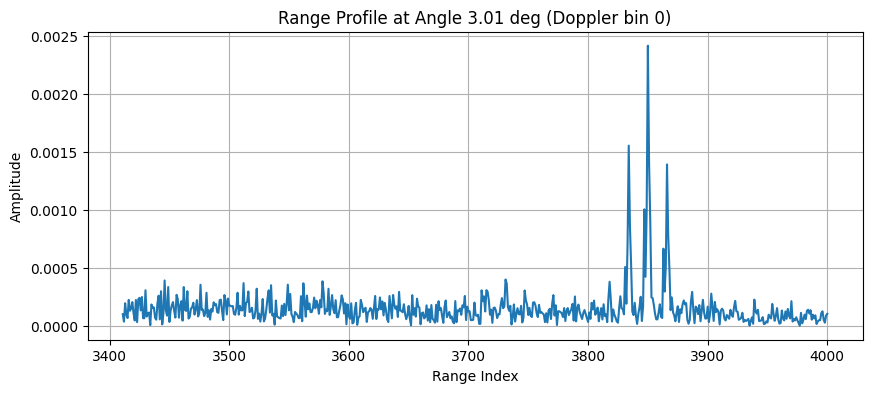

→ グラフを確認してください。鋭いピークが立っていれば成功です。
検出した距離： []
ターゲット不検出
1
rd_resp shape: (100, 590)
Saved: ./rd_maps\rd_map_0_for_0.png
[[-37.2  15.    1. ]]
Real Range: [293.21296015]
Real Velocity: [np.float64(5.876957141040797)]
TX after FFT: (16, 16384)
Y after FFT: (100, 16, 16384)

--- [Phase 2] Beamforming Result (i=0) ---
Angle: 2.98 deg
Y_F_combined shape (Trans, Freq): (100, 16384) <- アンテナ次元が消えているか確認
TX_F_combined shape (Freq,): (16384,)

--- [Phase 3] Correlation in Freq Domain (i=0) ---
CORR_f shape: (100, 16384)

--- [Phase 4] Time Domain / Range Profile (i=0) ---
rdresp_single shape (Trans, RangeBins): (100, 590)


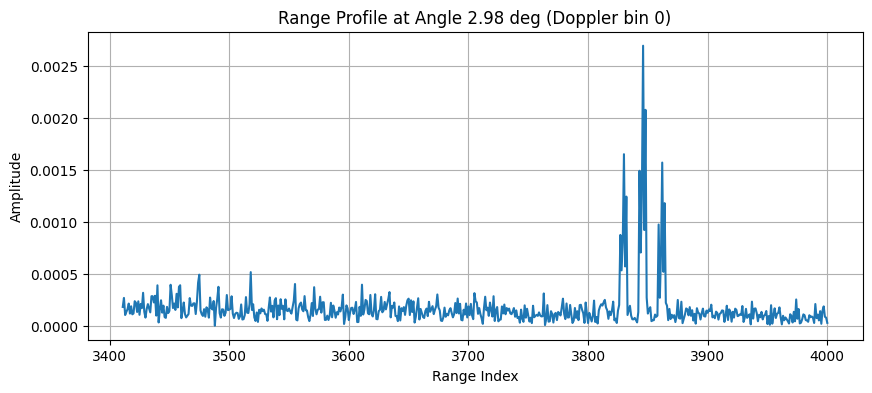

→ グラフを確認してください。鋭いピークが立っていれば成功です。
検出した距離： []
ターゲット不検出
1
rd_resp shape: (100, 590)
Saved: ./rd_maps\rd_map_1_for_0.png
[[-36.9  15.    1. ]]
Real Range: [292.91911853]
Real Velocity: [np.float64(5.876707565701734)]
TX after FFT: (16, 16384)
Y after FFT: (100, 16, 16384)

--- [Phase 2] Beamforming Result (i=0) ---
Angle: 2.99 deg
Y_F_combined shape (Trans, Freq): (100, 16384) <- アンテナ次元が消えているか確認
TX_F_combined shape (Freq,): (16384,)

--- [Phase 3] Correlation in Freq Domain (i=0) ---
CORR_f shape: (100, 16384)

--- [Phase 4] Time Domain / Range Profile (i=0) ---
rdresp_single shape (Trans, RangeBins): (100, 590)


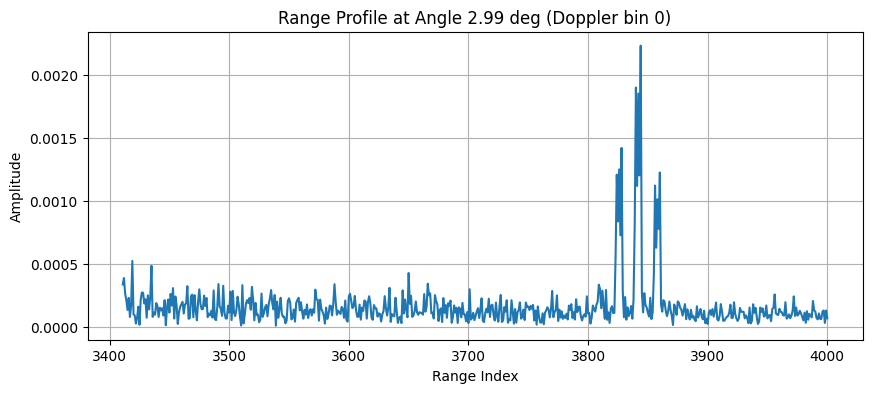

→ グラフを確認してください。鋭いピークが立っていれば成功です。
検出した距離： []
ターゲット不検出
1
rd_resp shape: (100, 590)
Saved: ./rd_maps\rd_map_2_for_0.png
[[-36.6  15.    1. ]]
Real Range: [292.62528941]
Real Velocity: [np.float64(5.8764572381630655)]
TX after FFT: (16, 16384)
Y after FFT: (100, 16, 16384)

--- [Phase 2] Beamforming Result (i=0) ---
Angle: 3.05 deg
Y_F_combined shape (Trans, Freq): (100, 16384) <- アンテナ次元が消えているか確認
TX_F_combined shape (Freq,): (16384,)

--- [Phase 3] Correlation in Freq Domain (i=0) ---
CORR_f shape: (100, 16384)

--- [Phase 4] Time Domain / Range Profile (i=0) ---
rdresp_single shape (Trans, RangeBins): (100, 590)


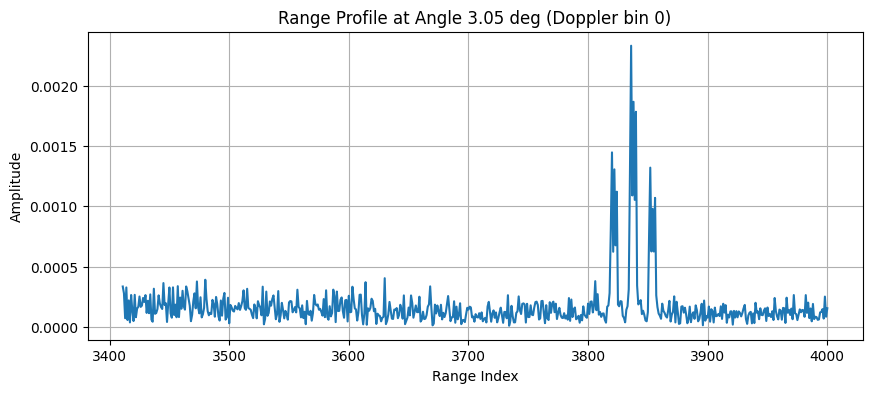

→ グラフを確認してください。鋭いピークが立っていれば成功です。
検出した距離： []
ターゲット不検出
1
rd_resp shape: (100, 590)
Saved: ./rd_maps\rd_map_3_for_0.png
[[-36.3  15.    1. ]]
Real Range: [292.33147282]
Real Velocity: [np.float64(5.876206155431227)]
TX after FFT: (16, 16384)
Y after FFT: (100, 16, 16384)

--- [Phase 2] Beamforming Result (i=0) ---
Angle: 3.04 deg
Y_F_combined shape (Trans, Freq): (100, 16384) <- アンテナ次元が消えているか確認
TX_F_combined shape (Freq,): (16384,)

--- [Phase 3] Correlation in Freq Domain (i=0) ---
CORR_f shape: (100, 16384)

--- [Phase 4] Time Domain / Range Profile (i=0) ---
rdresp_single shape (Trans, RangeBins): (100, 590)


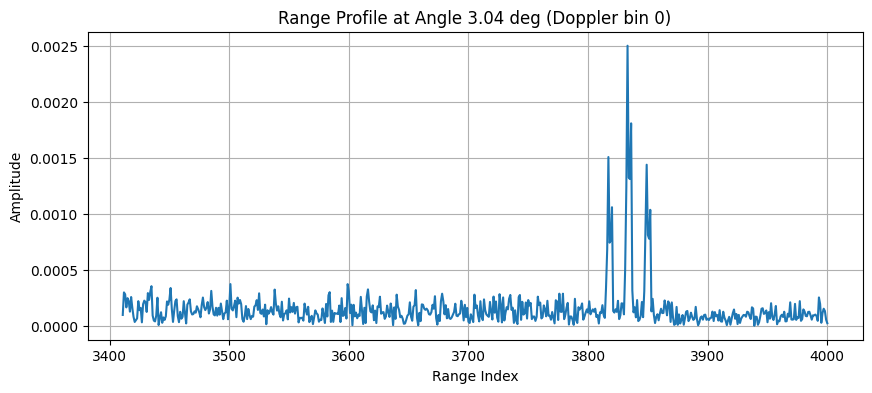

→ グラフを確認してください。鋭いピークが立っていれば成功です。
検出した距離： []
ターゲット不検出
1
rd_resp shape: (100, 590)
Saved: ./rd_maps\rd_map_4_for_0.png
[[-36.  15.   1.]]
Real Range: [292.0376688]
Real Velocity: [np.float64(5.875954314497913)]
TX after FFT: (16, 16384)
Y after FFT: (100, 16, 16384)

--- [Phase 2] Beamforming Result (i=0) ---
Angle: 3.07 deg
Y_F_combined shape (Trans, Freq): (100, 16384) <- アンテナ次元が消えているか確認
TX_F_combined shape (Freq,): (16384,)

--- [Phase 3] Correlation in Freq Domain (i=0) ---
CORR_f shape: (100, 16384)

--- [Phase 4] Time Domain / Range Profile (i=0) ---
rdresp_single shape (Trans, RangeBins): (100, 590)


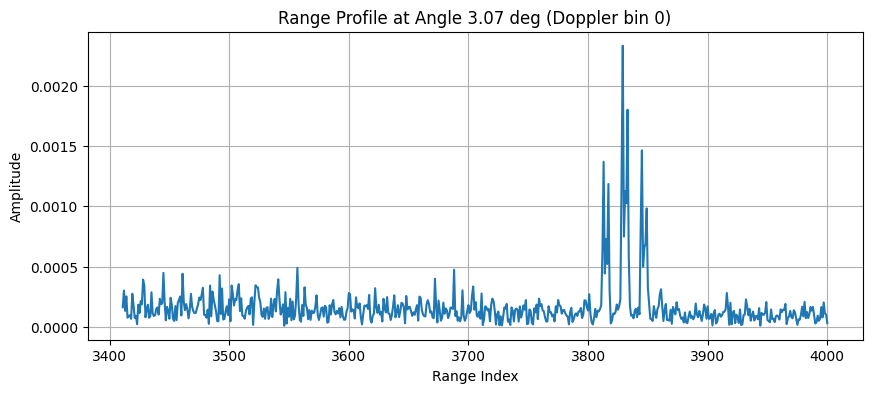

→ グラフを確認してください。鋭いピークが立っていれば成功です。
検出した距離： []
ターゲット不検出
1
rd_resp shape: (100, 590)
Saved: ./rd_maps\rd_map_5_for_0.png
[[-35.7  15.    1. ]]
Real Range: [291.7438774]
Real Velocity: [np.float64(5.875701712339994)]
TX after FFT: (16, 16384)
Y after FFT: (100, 16, 16384)

--- [Phase 2] Beamforming Result (i=0) ---
Angle: 3.03 deg
Y_F_combined shape (Trans, Freq): (100, 16384) <- アンテナ次元が消えているか確認
TX_F_combined shape (Freq,): (16384,)

--- [Phase 3] Correlation in Freq Domain (i=0) ---
CORR_f shape: (100, 16384)

--- [Phase 4] Time Domain / Range Profile (i=0) ---
rdresp_single shape (Trans, RangeBins): (100, 590)


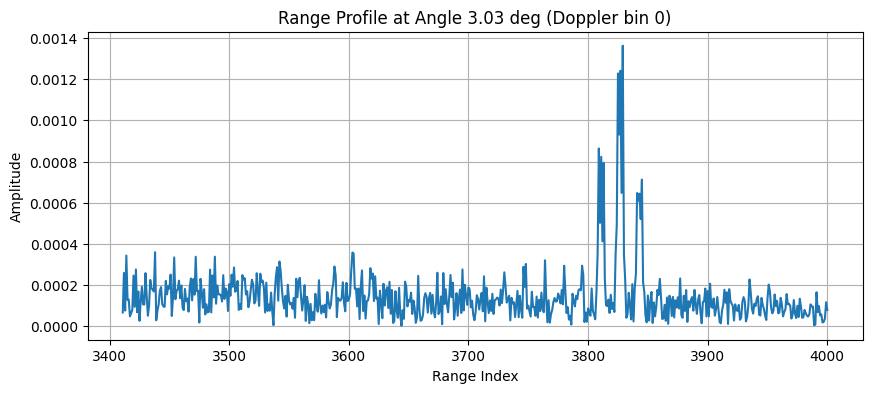

→ グラフを確認してください。鋭いピークが立っていれば成功です。
検出した距離： []
ターゲット不検出
1
rd_resp shape: (100, 590)
Saved: ./rd_maps\rd_map_6_for_0.png
[[-35.4  15.    1. ]]
Real Range: [291.45009864]
Real Velocity: [np.float64(5.875448345919418)]
TX after FFT: (16, 16384)
Y after FFT: (100, 16, 16384)

--- [Phase 2] Beamforming Result (i=0) ---
Angle: 3.06 deg
Y_F_combined shape (Trans, Freq): (100, 16384) <- アンテナ次元が消えているか確認
TX_F_combined shape (Freq,): (16384,)

--- [Phase 3] Correlation in Freq Domain (i=0) ---
CORR_f shape: (100, 16384)

--- [Phase 4] Time Domain / Range Profile (i=0) ---
rdresp_single shape (Trans, RangeBins): (100, 590)


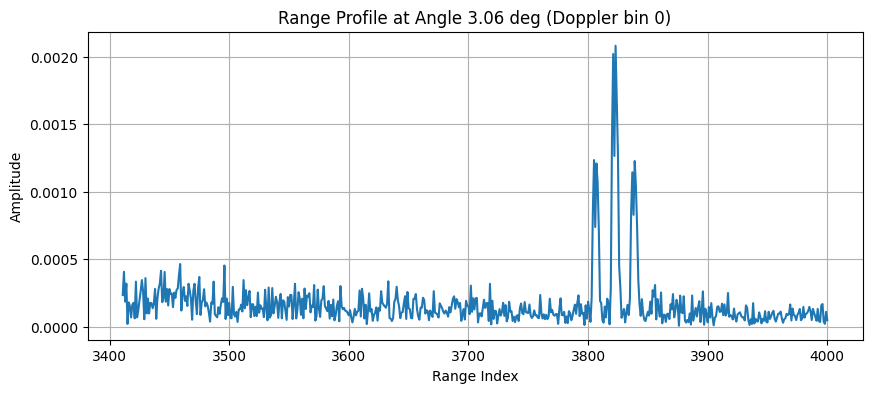

→ グラフを確認してください。鋭いピークが立っていれば成功です。
検出した距離： []
ターゲット不検出
1
rd_resp shape: (100, 590)
Saved: ./rd_maps\rd_map_7_for_0.png
[[-35.1  15.    1. ]]
Real Range: [291.15633258]
Real Velocity: [np.float64(5.8751942121831355)]
TX after FFT: (16, 16384)
Y after FFT: (100, 16, 16384)

--- [Phase 2] Beamforming Result (i=0) ---
Angle: 3.03 deg
Y_F_combined shape (Trans, Freq): (100, 16384) <- アンテナ次元が消えているか確認
TX_F_combined shape (Freq,): (16384,)

--- [Phase 3] Correlation in Freq Domain (i=0) ---
CORR_f shape: (100, 16384)

--- [Phase 4] Time Domain / Range Profile (i=0) ---
rdresp_single shape (Trans, RangeBins): (100, 590)


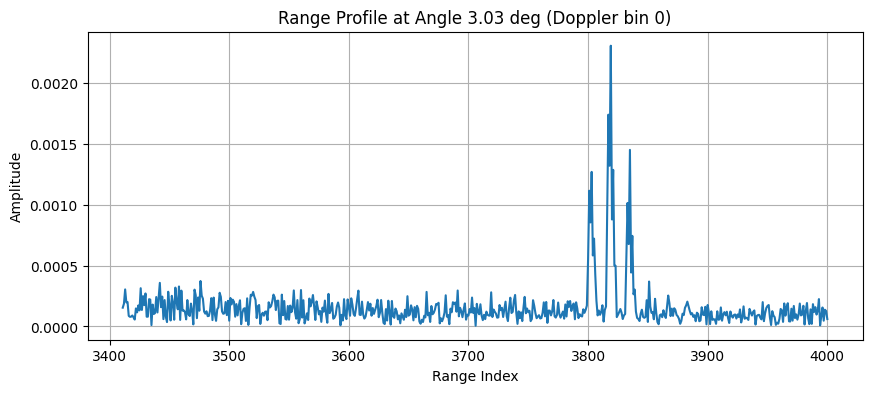

→ グラフを確認してください。鋭いピークが立っていれば成功です。
検出した距離： []
ターゲット不検出
1
rd_resp shape: (100, 590)
Saved: ./rd_maps\rd_map_8_for_0.png
[[-34.8  15.    1. ]]
Real Range: [290.86257924]
Real Velocity: [np.float64(5.874939308063002)]
TX after FFT: (16, 16384)
Y after FFT: (100, 16, 16384)

--- [Phase 2] Beamforming Result (i=0) ---
Angle: 3.08 deg
Y_F_combined shape (Trans, Freq): (100, 16384) <- アンテナ次元が消えているか確認
TX_F_combined shape (Freq,): (16384,)

--- [Phase 3] Correlation in Freq Domain (i=0) ---
CORR_f shape: (100, 16384)

--- [Phase 4] Time Domain / Range Profile (i=0) ---
rdresp_single shape (Trans, RangeBins): (100, 590)


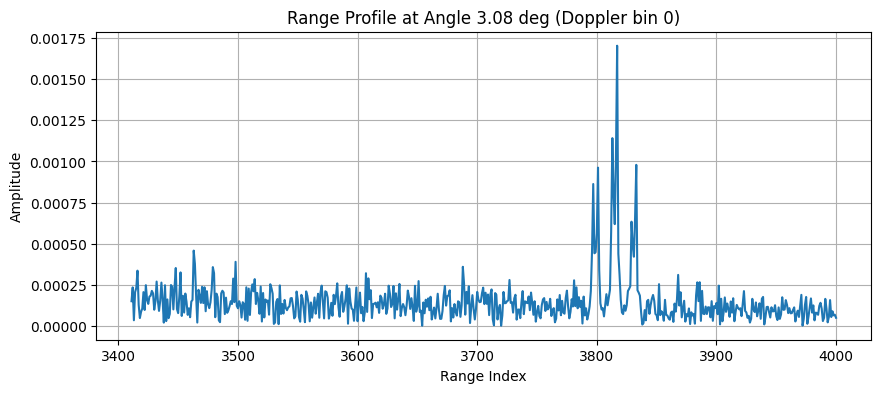

→ グラフを確認してください。鋭いピークが立っていれば成功です。
検出した距離： []
ターゲット不検出
1
rd_resp shape: (100, 590)
Saved: ./rd_maps\rd_map_9_for_0.png
[[-34.5  15.    1. ]]
Real Range: [290.56883866]
Real Velocity: [np.float64(5.874683630475695)]
TX after FFT: (16, 16384)
Y after FFT: (100, 16, 16384)

--- [Phase 2] Beamforming Result (i=0) ---
Angle: 3.06 deg
Y_F_combined shape (Trans, Freq): (100, 16384) <- アンテナ次元が消えているか確認
TX_F_combined shape (Freq,): (16384,)

--- [Phase 3] Correlation in Freq Domain (i=0) ---
CORR_f shape: (100, 16384)

--- [Phase 4] Time Domain / Range Profile (i=0) ---
rdresp_single shape (Trans, RangeBins): (100, 590)


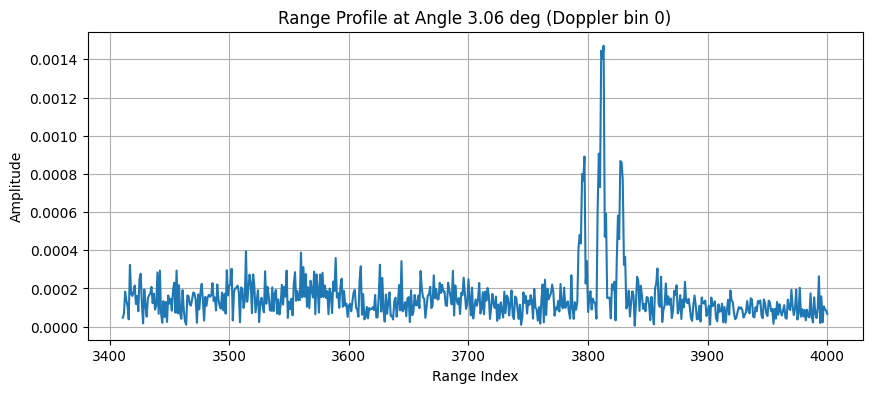

→ グラフを確認してください。鋭いピークが立っていれば成功です。
検出した距離： []
ターゲット不検出
1
rd_resp shape: (100, 590)
Saved: ./rd_maps\rd_map_10_for_0.png
[[-34.2  15.    1. ]]
Real Range: [290.27511089]
Real Velocity: [np.float64(5.874427176322623)]
TX after FFT: (16, 16384)
Y after FFT: (100, 16, 16384)

--- [Phase 2] Beamforming Result (i=0) ---
Angle: 3.07 deg
Y_F_combined shape (Trans, Freq): (100, 16384) <- アンテナ次元が消えているか確認
TX_F_combined shape (Freq,): (16384,)

--- [Phase 3] Correlation in Freq Domain (i=0) ---
CORR_f shape: (100, 16384)

--- [Phase 4] Time Domain / Range Profile (i=0) ---
rdresp_single shape (Trans, RangeBins): (100, 590)


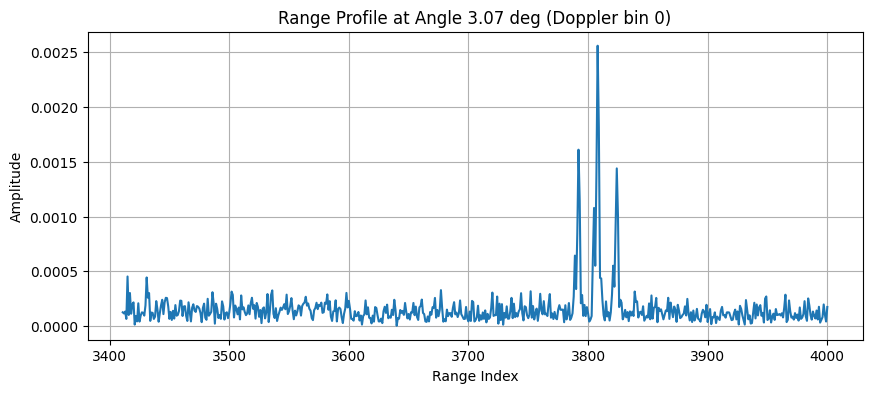

→ グラフを確認してください。鋭いピークが立っていれば成功です。
検出した距離： []
ターゲット不検出
1
rd_resp shape: (100, 590)
Saved: ./rd_maps\rd_map_11_for_0.png
[[-33.9  15.    1. ]]
Real Range: [289.98139595]
Real Velocity: [np.float64(5.874169942489841)]
TX after FFT: (16, 16384)
Y after FFT: (100, 16, 16384)

--- [Phase 2] Beamforming Result (i=0) ---
Angle: 3.09 deg
Y_F_combined shape (Trans, Freq): (100, 16384) <- アンテナ次元が消えているか確認
TX_F_combined shape (Freq,): (16384,)

--- [Phase 3] Correlation in Freq Domain (i=0) ---
CORR_f shape: (100, 16384)

--- [Phase 4] Time Domain / Range Profile (i=0) ---
rdresp_single shape (Trans, RangeBins): (100, 590)


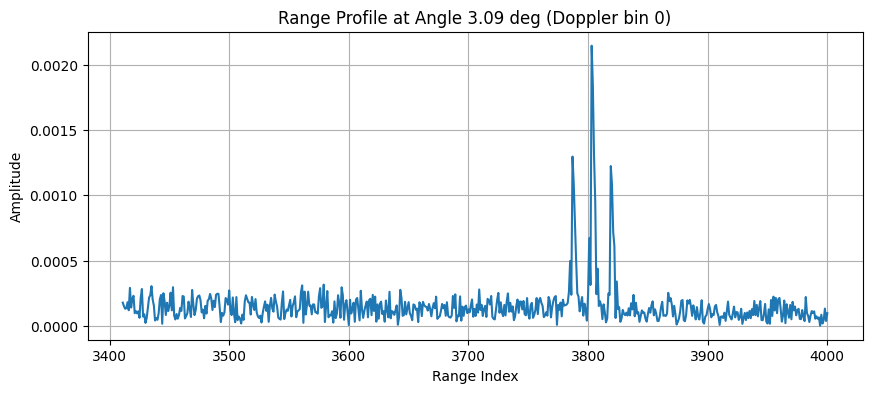

→ グラフを確認してください。鋭いピークが立っていれば成功です。
検出した距離： []
ターゲット不検出
1
rd_resp shape: (100, 590)
Saved: ./rd_maps\rd_map_12_for_0.png
[[-33.6  15.    1. ]]
Real Range: [289.68769391]
Real Velocity: [np.float64(5.873911925847948)]
TX after FFT: (16, 16384)
Y after FFT: (100, 16, 16384)

--- [Phase 2] Beamforming Result (i=0) ---
Angle: 3.09 deg
Y_F_combined shape (Trans, Freq): (100, 16384) <- アンテナ次元が消えているか確認
TX_F_combined shape (Freq,): (16384,)

--- [Phase 3] Correlation in Freq Domain (i=0) ---
CORR_f shape: (100, 16384)

--- [Phase 4] Time Domain / Range Profile (i=0) ---
rdresp_single shape (Trans, RangeBins): (100, 590)


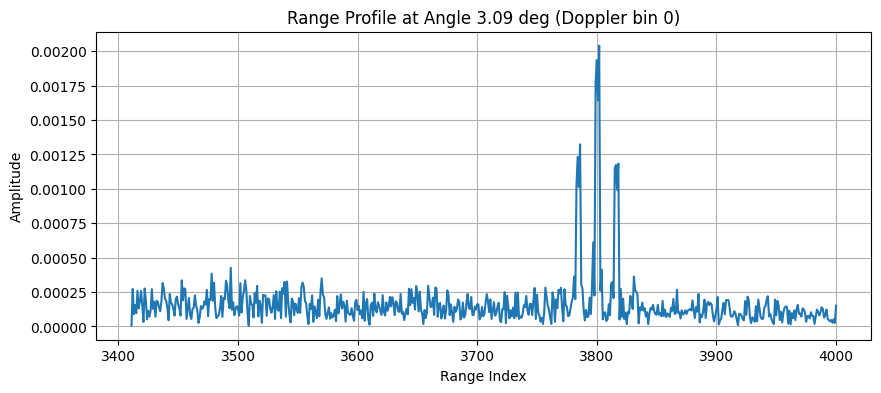

→ グラフを確認してください。鋭いピークが立っていれば成功です。
検出した距離： []
ターゲット不検出
1
rd_resp shape: (100, 590)
Saved: ./rd_maps\rd_map_13_for_0.png
[[-33.3  15.    1. ]]
Real Range: [289.39400478]
Real Velocity: [np.float64(5.873653123252007)]
TX after FFT: (16, 16384)
Y after FFT: (100, 16, 16384)

--- [Phase 2] Beamforming Result (i=0) ---
Angle: 3.07 deg
Y_F_combined shape (Trans, Freq): (100, 16384) <- アンテナ次元が消えているか確認
TX_F_combined shape (Freq,): (16384,)

--- [Phase 3] Correlation in Freq Domain (i=0) ---
CORR_f shape: (100, 16384)

--- [Phase 4] Time Domain / Range Profile (i=0) ---
rdresp_single shape (Trans, RangeBins): (100, 590)


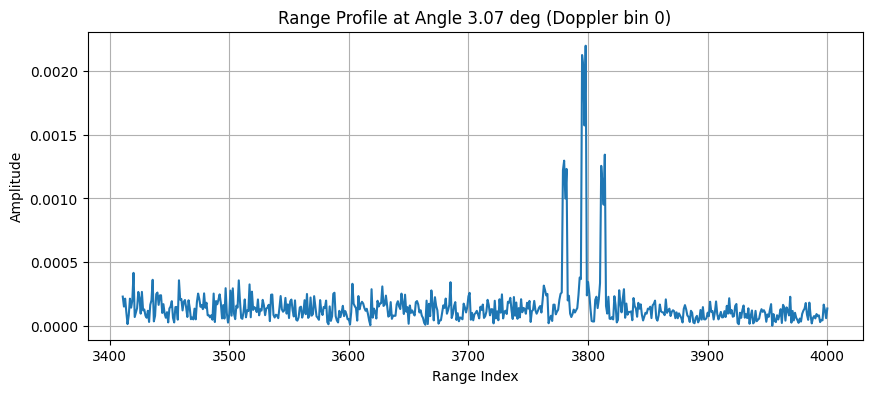

→ グラフを確認してください。鋭いピークが立っていれば成功です。
検出した距離： []
ターゲット不検出
1
rd_resp shape: (100, 590)
Saved: ./rd_maps\rd_map_14_for_0.png
[[-33.  15.   1.]]
Real Range: [289.10032861]
Real Velocity: [np.float64(5.873393531541447)]
TX after FFT: (16, 16384)
Y after FFT: (100, 16, 16384)

--- [Phase 2] Beamforming Result (i=0) ---
Angle: 3.07 deg
Y_F_combined shape (Trans, Freq): (100, 16384) <- アンテナ次元が消えているか確認
TX_F_combined shape (Freq,): (16384,)

--- [Phase 3] Correlation in Freq Domain (i=0) ---
CORR_f shape: (100, 16384)

--- [Phase 4] Time Domain / Range Profile (i=0) ---
rdresp_single shape (Trans, RangeBins): (100, 590)


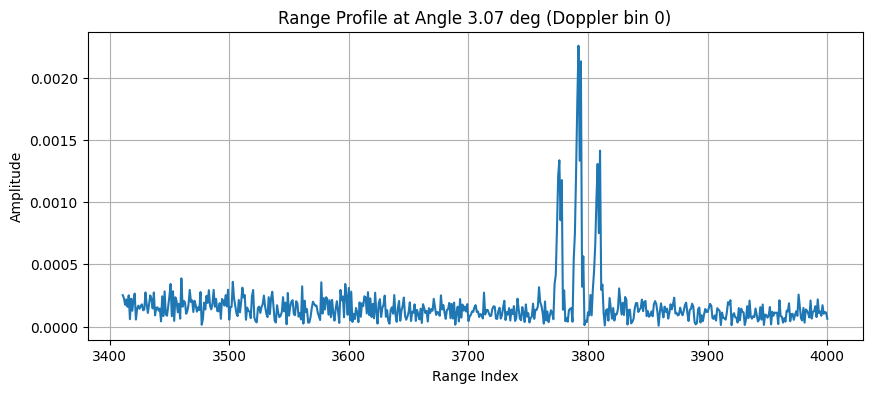

→ グラフを確認してください。鋭いピークが立っていれば成功です。
検出した距離： []
ターゲット不検出
1
rd_resp shape: (100, 590)
Saved: ./rd_maps\rd_map_15_for_0.png
[[-32.7  15.    1. ]]
Real Range: [288.80666544]
Real Velocity: [np.float64(5.873133147539979)]
TX after FFT: (16, 16384)
Y after FFT: (100, 16, 16384)

--- [Phase 2] Beamforming Result (i=0) ---
Angle: 3.13 deg
Y_F_combined shape (Trans, Freq): (100, 16384) <- アンテナ次元が消えているか確認
TX_F_combined shape (Freq,): (16384,)

--- [Phase 3] Correlation in Freq Domain (i=0) ---
CORR_f shape: (100, 16384)

--- [Phase 4] Time Domain / Range Profile (i=0) ---
rdresp_single shape (Trans, RangeBins): (100, 590)


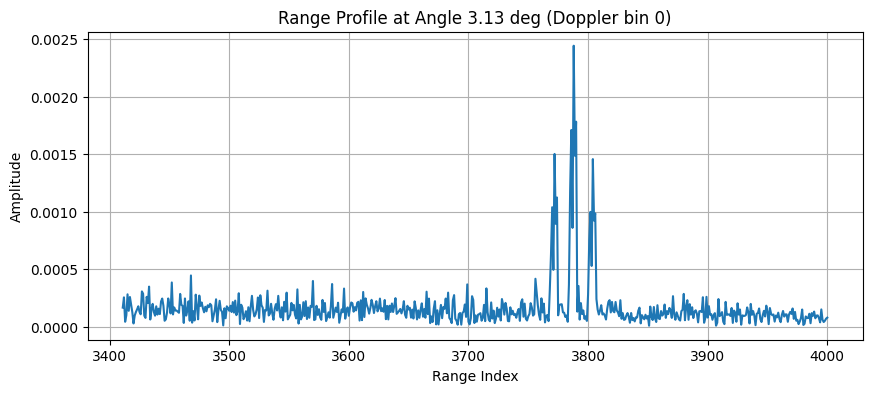

→ グラフを確認してください。鋭いピークが立っていれば成功です。
検出した距離： []
ターゲット不検出
1
rd_resp shape: (100, 590)
Saved: ./rd_maps\rd_map_16_for_0.png
[[-32.4  15.    1. ]]
Real Range: [288.5130153]
Real Velocity: [np.float64(5.8728719680554935)]
TX after FFT: (16, 16384)
Y after FFT: (100, 16, 16384)

--- [Phase 2] Beamforming Result (i=0) ---
Angle: 3.11 deg
Y_F_combined shape (Trans, Freq): (100, 16384) <- アンテナ次元が消えているか確認
TX_F_combined shape (Freq,): (16384,)

--- [Phase 3] Correlation in Freq Domain (i=0) ---
CORR_f shape: (100, 16384)

--- [Phase 4] Time Domain / Range Profile (i=0) ---
rdresp_single shape (Trans, RangeBins): (100, 590)


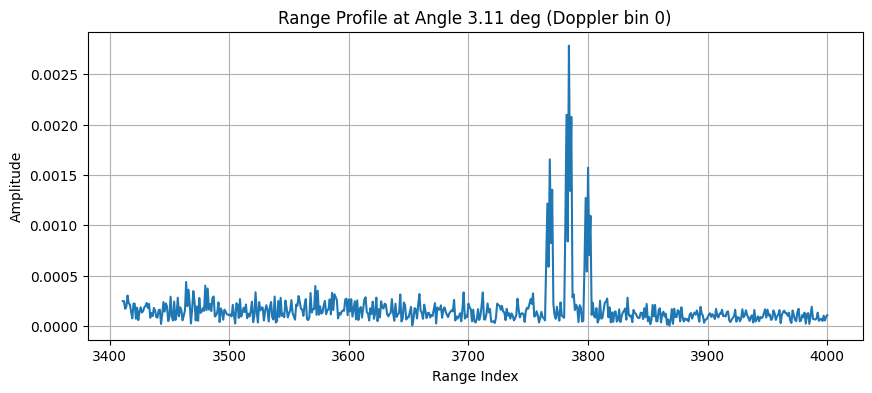

→ グラフを確認してください。鋭いピークが立っていれば成功です。
検出した距離： []
ターゲット不検出
1
rd_resp shape: (100, 590)
Saved: ./rd_maps\rd_map_17_for_0.png
[[-32.1  15.    1. ]]
Real Range: [288.21937825]
Real Velocity: [np.float64(5.872609989879969)]
TX after FFT: (16, 16384)
Y after FFT: (100, 16, 16384)

--- [Phase 2] Beamforming Result (i=0) ---
Angle: 3.18 deg
Y_F_combined shape (Trans, Freq): (100, 16384) <- アンテナ次元が消えているか確認
TX_F_combined shape (Freq,): (16384,)

--- [Phase 3] Correlation in Freq Domain (i=0) ---
CORR_f shape: (100, 16384)

--- [Phase 4] Time Domain / Range Profile (i=0) ---
rdresp_single shape (Trans, RangeBins): (100, 590)


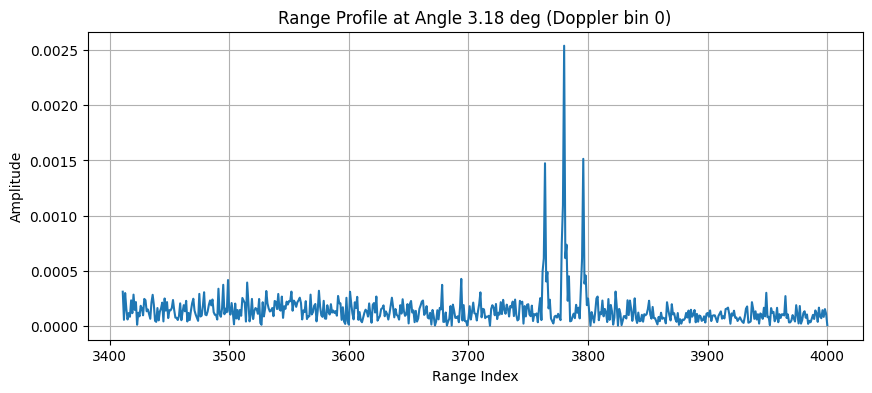

→ グラフを確認してください。鋭いピークが立っていれば成功です。
検出した距離： []
ターゲット不検出
1
rd_resp shape: (100, 590)
Saved: ./rd_maps\rd_map_18_for_0.png
[[-31.8  15.    1. ]]
Real Range: [287.92575432]
Real Velocity: [np.float64(5.872347209789386)]
TX after FFT: (16, 16384)
Y after FFT: (100, 16, 16384)

--- [Phase 2] Beamforming Result (i=0) ---
Angle: 3.14 deg
Y_F_combined shape (Trans, Freq): (100, 16384) <- アンテナ次元が消えているか確認
TX_F_combined shape (Freq,): (16384,)

--- [Phase 3] Correlation in Freq Domain (i=0) ---
CORR_f shape: (100, 16384)

--- [Phase 4] Time Domain / Range Profile (i=0) ---
rdresp_single shape (Trans, RangeBins): (100, 590)


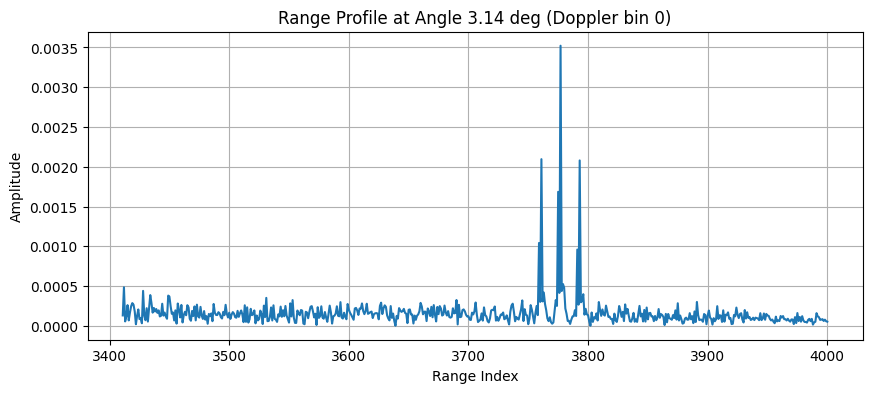

→ グラフを確認してください。鋭いピークが立っていれば成功です。
検出した距離： []
ターゲット不検出
1
rd_resp shape: (100, 590)
Saved: ./rd_maps\rd_map_19_for_0.png
[[-31.5  15.    1. ]]
Real Range: [287.63214354]
Real Velocity: [np.float64(5.872083624543623)]
TX after FFT: (16, 16384)
Y after FFT: (100, 16, 16384)

--- [Phase 2] Beamforming Result (i=0) ---
Angle: 3.14 deg
Y_F_combined shape (Trans, Freq): (100, 16384) <- アンテナ次元が消えているか確認
TX_F_combined shape (Freq,): (16384,)

--- [Phase 3] Correlation in Freq Domain (i=0) ---
CORR_f shape: (100, 16384)

--- [Phase 4] Time Domain / Range Profile (i=0) ---
rdresp_single shape (Trans, RangeBins): (100, 590)


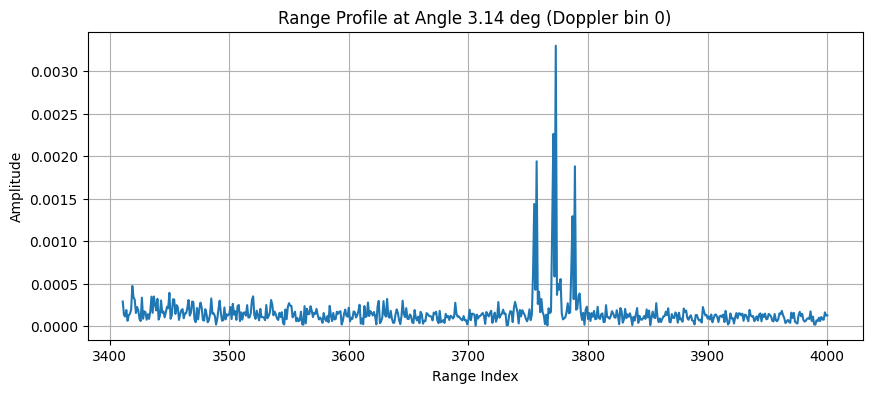

→ グラフを確認してください。鋭いピークが立っていれば成功です。
検出した距離： []
ターゲット不検出
1
rd_resp shape: (100, 590)
Saved: ./rd_maps\rd_map_20_for_0.png

Data generation complete.
Saved 'measurements.csv'.


In [22]:
###### symbol time & carrier frequency ######
T_symbol = 1.115 * 1e-6              # 一つのチャープ信号の継続時間
T_OFDM = 1.0425 * 1e-6
f_carrier = 28 * 1e+9               # 搬送波周波数(チャープが使用する周波数帯域の中心)
Tc = 0.509*1e-9                      # サンプリング時間(アナログ波形の情報をデジタルデータとして取得する際の時間間隔)

###### tx/rx ######
N_ant = 16                                      # アンテナの数
BW = 1.966080e+9                                # チャープの帯域幅
BW_sub = BW/N_ant                               # サブチャープの帯域幅(全アンテナで全帯域幅を分け合う)  
N_sample = int(np.floor(T_symbol/Tc))           # 一回のチャープで送信するサンプル数(チャープ信号そのものの長さ)
offset = 4000
rx_sample = offset + N_sample                   # 一回のチャープで受信するサンプル数(受信バッファの長さ)



###### Radar setting ######

N_chirp = 100                    # チャープの数
mu = BW_sub/T_symbol * 0.98      # チャープの傾き
print(N_sample)
Q = 30                           # 使ってない？
Phi = 0.3*np.pi                  # 使ってない？

l_speed = 299792458              # 光速

N_trans = 100                    # ドップラーDFTの点数(一回の速度計測のために送信するチャープ信号の連射数)

refangle = np.arctan(33/265)/2   # 基準角度の設定(cyclist_env_RDA.pyより)


env = cyclist_env(f_carrier, N_ant, BW, BW_sub, N_sample, rx_sample, Tc, mu, l_speed)
# 送信信号の生成(行列:アンテナ数、列:サンプル数)
tx = env.tx()
print(tx.shape)

# シミュレーション設定
p_bs = np.array([250, -18, 50])                         #基地局の位置

# 各車両の数
num_cy = 1
num_ve = 0
num_rp = 0
# シミュレーション範囲の設定
#start_cy_idx = 135
#start_ve_idx = 150
start_cy_idx = 75
start_ve_idx = 50

#end_cy_idx = 300
#end_ve_idx = 3
end_cy_idx = 135
end_ve_idx = 150

cy_interval = 3
ve_interval = 5

cy_v_value = 6
ve_v_value = 10

cy_idx = start_cy_idx
ve_idx = start_ve_idx

measurement_history = []
frame_count = 0

# 繰り返し処理
while cy_idx <= end_cy_idx and ve_idx <= end_ve_idx:
    x_pos = list(np.arange(-450, -149)/10)                  #x座標のリスト
    
    Y, phys_quantities = get_snapshot_data(cy_idx,ve_idx,x_pos,p_bs, tx, cy_v_value, ve_v_value, num_cy, num_ve, num_rp)
    print("Real Range:", phys_quantities["range"]["cyclists"])
    print("Real Velocity:", phys_quantities["relative_velocity"]["cyclists"])
    #est_ang = MUSIC_method(Y, N_ant)
    est_ang = MUSIC_method_improved(Y, N_ant, num_cy + num_ve + num_rp)
    #est_ang = Root_MUSIC_method(Y, N_ant, num_cy + num_ve + num_rp)
    
    #detected_objects, rd_maps = DFT(N_trans, N_ant, rx_sample, Y, tx, N_sample, est_ang)
    detected_objects, rd_maps = FFT(N_trans, N_ant, rx_sample, Y, tx, N_sample, est_ang)
    #plot_rd_maps(rd_maps, est_ang)
    RD_MAP(rd_maps, frame_count, save_dir="./rd_maps")
    
    if len(detected_objects) > 0:
        for obj in detected_objects:
            measurement_history.append({
                "Time": frame_count,  # 時刻（フレーム番号）
                "Range": obj[0],      # 距離 [m]
                "Angle": obj[1],      # 角度 [度]
                "X": obj[2],          # X座標 [m]
                "Y": obj[3]           # Y座標 [m]
            })
    else:
        # 何も検出されなかった場合も、時刻だけ記録したい場合は以下のようにNaNを入れる
        # (不要であればこのelseブロックは削除してください)
        measurement_history.append({
            "Time": frame_count,
            "Range": np.nan,
            "Angle": np.nan,
            "X": np.nan,
            "Y": np.nan
        })
    
    cy_idx += cy_interval
    ve_idx += ve_interval
    frame_count += 1
    
# csvファイルに保存
# --- 6. CSVへの保存 ---
df_measurements = pd.DataFrame(measurement_history)

# 保存
csv_filename = "measurements.csv"
df_measurements.to_csv(csv_filename, index=False)

print("\nData generation complete.")
print(f"Saved '{csv_filename}'.")


In [ ]:
import imageio
import glob
import os
import math

def create_split_gifs(image_folder, output_prefix, frames_per_gif=100, duration=0.1):
    """
    指定した枚数ごとにGIFを分割して作成します。
    
    image_folder: 画像フォルダ
    output_prefix: 出力ファイル名の接頭辞 (例: "radar_movie") -> "radar_movie_part1.gif" になります
    frames_per_gif: 1つのGIFに含める画像の枚数 (iがこの数増えるごとに新しいGIFを作ります)
    duration: フレーム速度
    """
    
    # 1. 画像ファイルの取得
    search_path = os.path.join(image_folder, "*.png")
    files = glob.glob(search_path)
    
    if not files:
        print("画像が見つかりませんでした。")
        return

    # 2. ファイル名 "rd_map_{id}_for_{i}.png" の {i} を基準にソート
    def get_sort_key(filepath):
        try:
            filename = os.path.basename(filepath)
            # "_for_" の後ろの数字を取得
            return int(filename.split('_for_')[-1].replace('.png', ''))
        except:
            return 0

    files.sort(key=get_sort_key)
    
    total_files = len(files)
    print(f"合計 {total_files} 枚の画像が見つかりました。")
    print(f"{frames_per_gif} 枚ごとに分割してGIFを作成します。")

    # 3. 分割してGIF作成
    # 0からtotal_filesまで、frames_per_gif ずつステップしてループ
    num_parts = math.ceil(total_files / frames_per_gif)
    
    for part_idx, start_idx in enumerate(range(0, total_files, frames_per_gif)):
        # 今回のバッチ処理するファイルリストをスライス
        end_idx = start_idx + frames_per_gif
        batch_files = files[start_idx : end_idx]
        
        images = []
        for filename in batch_files:
            images.append(imageio.imread(filename))
            
        # ファイル名を決定 (例: radar_movie_part01.gif)
        # part_idx + 1 にして 1から始まる番号にします
        output_name = f"{output_prefix}_part{part_idx + 1:02d}.gif"
        
        imageio.mimsave(output_name, images, duration=duration, loop=0)
        
        # 進捗表示
        first_i = get_sort_key(batch_files[0])
        last_i = get_sort_key(batch_files[-1])
        print(f"[{part_idx + 1}/{num_parts}] Saved: {output_name} (i={first_i} to {last_i})")

# --- 実行設定 ---
target_folder = "./rd_maps/" 

# ここで「何枚ごとに1つのGIFにするか」を設定します
# 例: 50枚ごとに区切るなら 50 を指定
create_split_gifs(
    image_folder=target_folder, 
    output_prefix="rd_map_animation", 
    frames_per_gif=50,  # <--- ここで枚数を調整
    duration=0.1
)

合計 32 枚の画像が見つかりました。
50 枚ごとに分割してGIFを作成します。


C:\Users\kousu\AppData\Local\Temp\ipykernel_30820\3459896525.py:50: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


[1/1] Saved: rd_map_animation_part01.gif (i=0 to 1)
